In [1]:
import os
import numpy as np
import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Conv2DTranspose, Reshape, LeakyReLU, Flatten, Dense, UpSampling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tqdm.keras import TqdmCallback

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print('Tensorflow version', tf.__version__)
from functools import partial
from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgba2rgb, gray2rgb
# from skimage.color import rgb2gray, rgba2rgb

latent_dim = 128

Using TensorFlow backend.


Tensorflow version 2.1.0


(512, 512, 3)

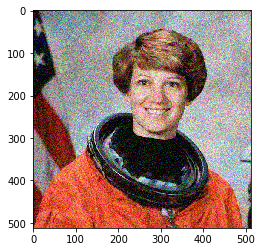

In [2]:
from skimage.io import imread

# for denoising
def load_img(path, img_name):
    img_path = os.path.join(path, img_name + ".png")
    img = imread(img_path)
    if len(img.shape) == 2:
        img = img[:, :, None]
    img_clean = img / 255.
    return img_clean

def noisy_img(img, sig=30, noise_same=False):
    """Returns noisy version of the input image"""
    sigma = sig / 255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img.shape[:-1])
        noise = np.stack([noise] * img.shape[-1], axis=-1)
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img.shape)

    img_noisy = np.clip(img + noise, 0, 1).astype(np.float32)
    return img_noisy

img_clean = load_img('test_data/', 'astronaut')
plt.imshow(img_clean)
img_noisy = noisy_img(img_clean)
plt.imshow(img_noisy)
img_noisy.shape

In [3]:
optimizer = Adam(0.0002, 0.5)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=200,
#     decay_rate=0.65)
# optimizer = Adam(learning_rate=lr_schedule)

def train_and_save(model, path, **kwargs):
    if path.exists():  
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
        model.load_weights(str(path))
        _ = model.fit(**kwargs)
        model.save_weights(str(path))
    else:
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
        _ = model.fit(**kwargs)
        model.save_weights(str(path))

In [4]:
def build_decoder():
    decoder = tf.keras.models.Sequential()
    for _ in range(5):
        decoder.add(
            Conv2D(filters=latent_dim, kernel_size=1, strides=1, padding='valid', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.1), input_shape=(16, 16, 128)))
        decoder.add(UpSampling2D(interpolation='bilinear'))
        decoder.add(Activation('relu'))
        decoder.add(BatchNormalization())

    # 2nd last layer
    decoder.add(
        Conv2D(filters=latent_dim, kernel_size=1, strides=1, padding='valid', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)))
    decoder.add(Activation('relu'))
    decoder.add(BatchNormalization())

    # last layer
    decoder.add(
        Conv2D(filters=3, kernel_size=1, padding='valid', activation='sigmoid', use_bias=False, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)))
    
    return decoder



In [5]:
decoder = build_decoder()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       16384     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       16384     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 128)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0

In [6]:
def plot_decoded_images(decoder, examples=9, dim=(3, 3), figsize=(10, 10)):
    latent_code_shape = [examples, 16, 16, latent_dim]
    latent_code = np.random.normal(size=latent_code_shape)
    decoded_images = decoder.predict(latent_code)
    plt.figure(figsize=figsize)
    for i in range(decoded_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(decoded_images[i], interpolation='nearest', cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()

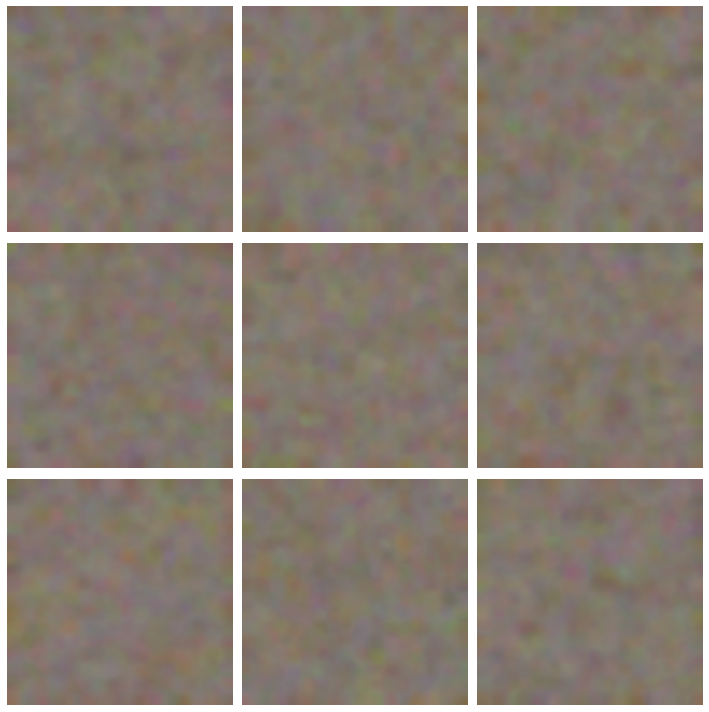

In [7]:
plot_decoded_images(decoder)

In [8]:
latent_code_shape = [16, 16, latent_dim]
latent_code = np.reshape(np.random.normal(size=latent_code_shape), [1, 16, 16, latent_dim])
latent_code.shape, img_clean.shape, img_noisy.shape

((1, 16, 16, 128), (512, 512, 3), (512, 512, 3))

In [10]:
pwd()

'/Users/dongdong/Desktop/dsa5204/Demos'

In [11]:
# denoising with noise image
y = np.reshape(img_noisy, (1, 512, 512, 3))
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

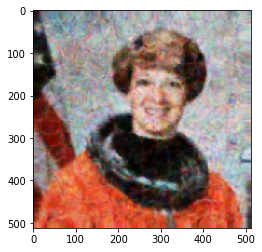

In [12]:
out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

In [13]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

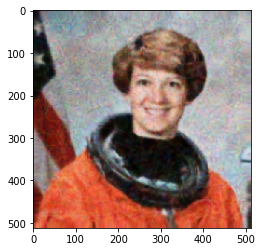

In [14]:
out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

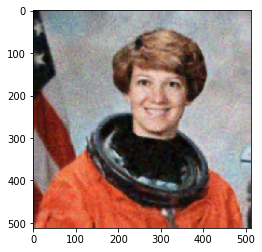

In [15]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

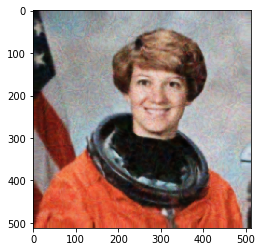

In [16]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

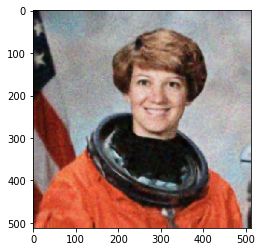

In [17]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

In [18]:
def psnr(x_hat, x_true, maxv=1.):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse=np.mean(np.square(x_hat - x_true))
    psnr_ = 10. * np.log(maxv** 2 /mse) / np.log(10.)
    return psnr_

def plot_results(out_img, img_clean, img_noisy):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))
    
    ax1.imshow(img_clean)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2.imshow(img_noisy)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean, img_noisy))
    ax2.axis('off')

    ax3.imshow(out_img)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_clean, out_img)) 
    ax3.axis('off')    
    plt.show()
    

In [19]:
img_clean.shape, img_noisy.shape, out_img.shape

((512, 512, 3), (512, 512, 3), (512, 512, 3))

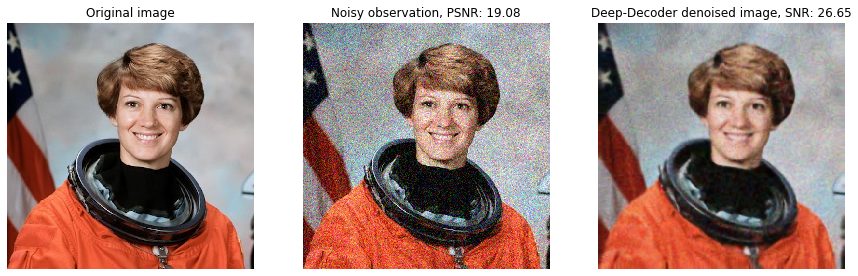

In [20]:
plot_results(out_img, img_clean, img_noisy)

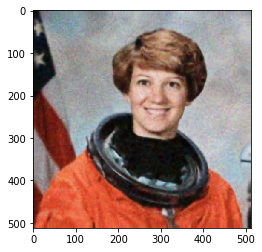

In [21]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=100,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img) # 6*100 epoch

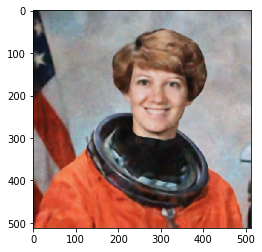

In [22]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100,
    decay_rate=0.65)
optimizer = Adam(learning_rate=lr_schedule)

train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise_decay.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=300,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

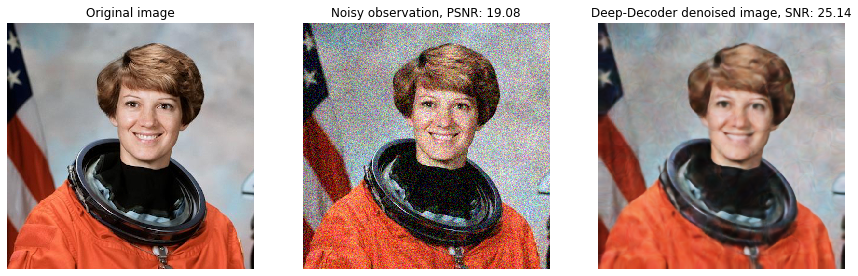

In [23]:
plot_results(out_img, img_clean, img_noisy)

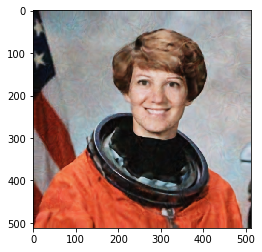

In [24]:
train_and_save(
    model=decoder,
    path=Path('./deepdecoder_denoise_decay.h5'),
    x=latent_code,
    y=y,
    batch_size=1,
    verbose=0,
    epochs=1000,
    callbacks=[TqdmCallback(verbose=1)],
)

out_img = decoder.predict(latent_code)[0]
plt.imshow(out_img)

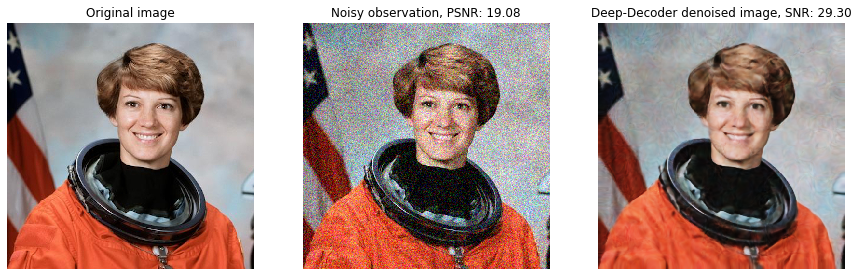

In [25]:
plot_results(out_img, img_clean, img_noisy)

In [ ]:
def inpaint_img(img):
    mask = load_mask('test_data/')
    img_noisy = img * mask
    return img_noisy, mask

img_clean_inpaint = load_img('test_data/', 'poster')


def recover(img_noisy, img_clean, mask, epoch=800):
    train_and_save(
        model=decoder,
        path=Path('./deepdecoder_denoise_decay.h5'),
        x=latent_code,
        y=y,
        batch_size=1,
        verbose=0,
        epochs=1000,
        callbacks=[TqdmCallback(verbose=1)],
    )

    

In [ ]:
img_noisy, mask = inpaint_img(img_clean)
out_img, _ = recover(img_noisy, img_clean, mask, epoch=1000)
plot_results(out_img, img_clean, img_noisy)
